## Stock Market Prediction using LSTM

### Import Libarries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
data = pd.read_csv('NSE-TATAGLOBAL.csv')

In [3]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
data.shape

(2035, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [6]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [7]:
data.dtypes

Date                     object
Open                    float64
High                    float64
Low                     float64
Last                    float64
Close                   float64
Total Trade Quantity      int64
Turnover (Lacs)         float64
dtype: object

In [8]:
data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

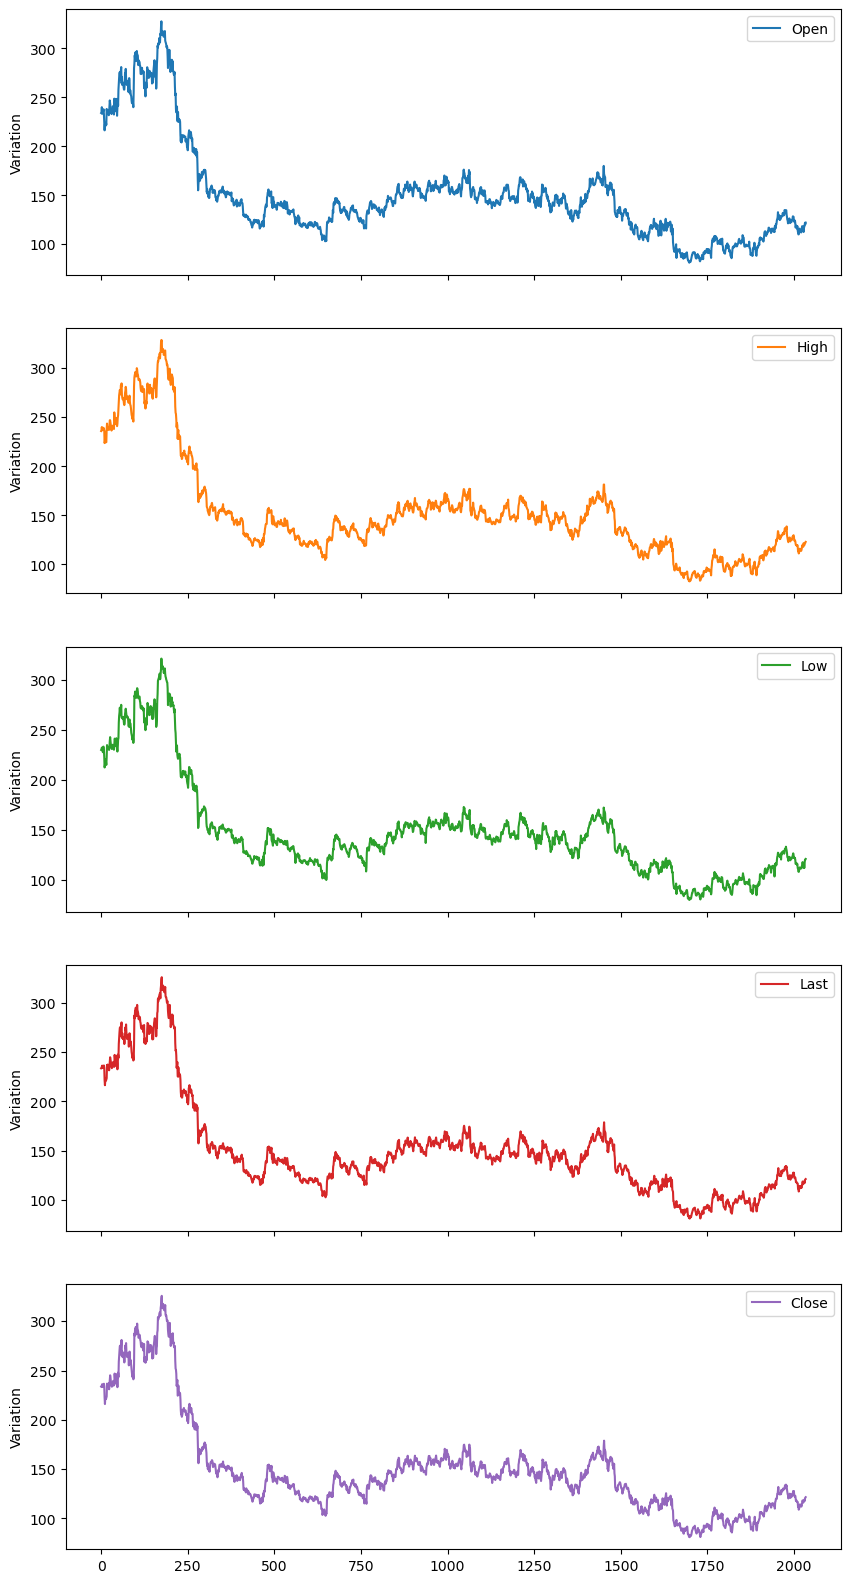

In [9]:
columns = ['Open','High','Low','Last','Close']

axes = data[columns].plot(alpha = 1, figsize = (10, 20), subplots = True)

for ax in axes:

    ax.set_ylabel('Variation')

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>,
        <Axes: title={'center': 'Low'}>],
       [<Axes: title={'center': 'Last'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Total Trade Quantity'}>],
       [<Axes: title={'center': 'Turnover (Lacs)'}>, <Axes: >, <Axes: >]],
      dtype=object)

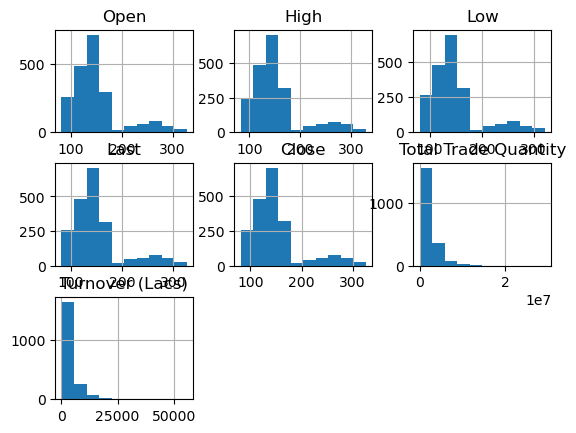

In [10]:
data.hist()

<Axes: >

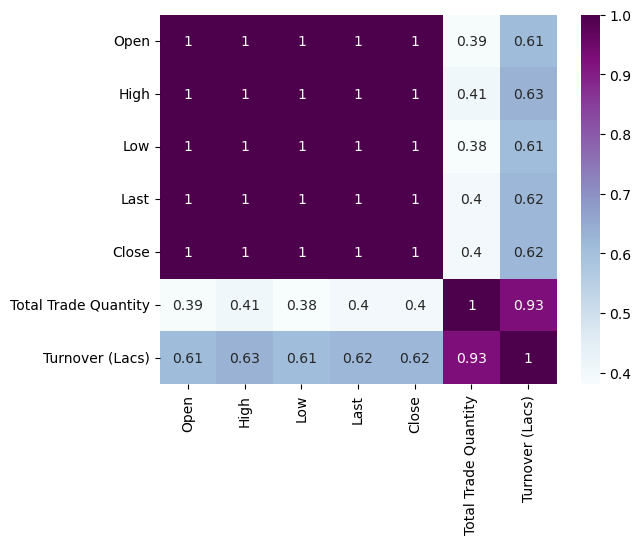

In [11]:
sns.heatmap(data.corr(), annot = True,cmap = 'BuPu')

<Axes: ylabel='Turnover (Lacs)'>

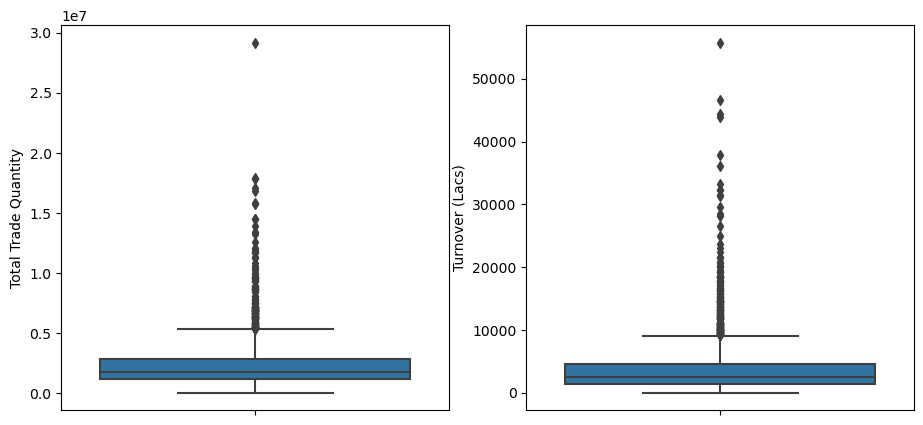

In [12]:
plt.figure(figsize = (11,5))

plt.subplot(1,2,1)
sns.boxplot(data = data, y = 'Total Trade Quantity')

plt.subplot(1,2,2)
sns.boxplot(data = data, y = 'Turnover (Lacs)')

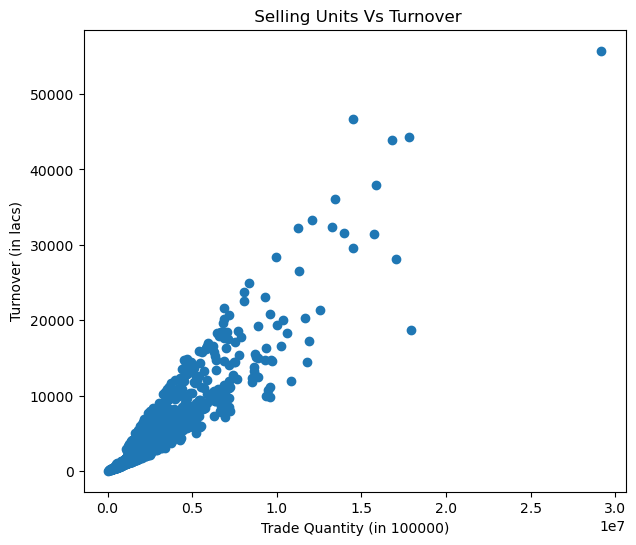

In [13]:
fig = plt.figure(figsize = (7,6))

plt.scatter(data['Total Trade Quantity'], data['Turnover (Lacs)'])

plt.xlabel("Trade Quantity (in 100000)")
plt.ylabel("Turnover (in lacs)")
plt.title(" Selling Units Vs Turnover")

plt.show()

In [14]:
data1 = data.reset_index()['Close']
data1

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

### Feature Sacaling

In [15]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler

scaler = MinMaxScaler(feature_range = (0,1))
train_scaler = scaler.fit_transform(np.array(data1).reshape(-1, 1))

### splitting dataset into train and test split

In [16]:
train_size = int(len(train_scaler) * 0.65)
test_size = int(len(train_scaler)) - train_size
train_data, test_data = train_scaler[0 : train_size, :], train_scaler[train_size : len(data), : 1] 

### convert an array of values into a dataset matrix

In [17]:
def create_dataset(dataset, time_step = 1):
    train_X, train_Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]   
        train_X.append(a)
        train_Y.append(dataset[i + time_step, 0])
    return np.array(train_X), np.array(train_Y)

In [18]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1221, 100), (1221,), (612, 100), (612,))

### reshape input to be [samples, time steps, features] which is required for LSTM

In [20]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Create the Stacked LSTM model

In [21]:
model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
20/20 [==============================] - 21s 483ms/step - loss: 0.0274 - val_loss: 0.0033
Epoch 2/100
20/20 [==============================] - 7s 366ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 3/100
20/20 [==============================] - 7s 352ms/step - loss: 0.0017 - val_loss: 8.5199e-04
Epoch 4/100
20/20 [==============================] - 7s 362ms/step - loss: 0.0016 - val_loss: 9.1809e-04
Epoch 5/100
20/20 [==============================] - 7s 360ms/step - loss: 0.0015 - val_loss: 8.2993e-04
Epoch 6/100
20/20 [==============================] - 7s 349ms/step - loss: 0.0015 - val_loss: 8.4321e-04
Epoch 7/100
20/20 [==============================] - 7s 365ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
20/20 [==============================] - 7s 362ms/step - loss: 0.0013 - val_loss: 8.8359e-04
Epoch 9/100
20/20 [==============================] - 7s 348ms/step - loss: 0.0013 - val_loss: 9.6828e-04
Epoch 10/100
20/20 [==============================] - 7s 362ms/ste

20/20 [==============================] - 7s 327ms/step - loss: 2.8813e-04 - val_loss: 4.9551e-04
Epoch 77/100
20/20 [==============================] - 7s 325ms/step - loss: 3.6808e-04 - val_loss: 2.6924e-04
Epoch 78/100
20/20 [==============================] - 7s 332ms/step - loss: 2.9936e-04 - val_loss: 3.2284e-04
Epoch 79/100
20/20 [==============================] - 7s 337ms/step - loss: 3.0129e-04 - val_loss: 2.6078e-04
Epoch 80/100
20/20 [==============================] - 7s 351ms/step - loss: 3.8112e-04 - val_loss: 3.7577e-04
Epoch 81/100
20/20 [==============================] - 7s 328ms/step - loss: 2.8315e-04 - val_loss: 3.5979e-04
Epoch 82/100
20/20 [==============================] - 6s 327ms/step - loss: 3.2066e-04 - val_loss: 2.9789e-04
Epoch 83/100
20/20 [==============================] - 6s 316ms/step - loss: 3.1903e-04 - val_loss: 2.5497e-04
Epoch 84/100
20/20 [==============================] - 6s 313ms/step - loss: 2.6467e-04 - val_loss: 2.2789e-04
Epoch 85/100
20/20 [===

### Lets Do the prediction and check performance metrics

In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

20/20 [==============================] - 1s 59ms/step


In [25]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics

In [26]:
math.sqrt(mean_squared_error(y_train,train_predict))

164.86037790776396

In [27]:
math.sqrt(mean_squared_error(y_test,test_predict))

115.05942773769347

### shift train and test predictions for plotting

In [28]:
look_back = 100
trainPredictPlot = np.empty_like(train_scaler)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

In [29]:
testPredictPlot = np.empty_like(train_scaler)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1 : len(data1)-1, :] = test_predict

### plot baseline and prediction

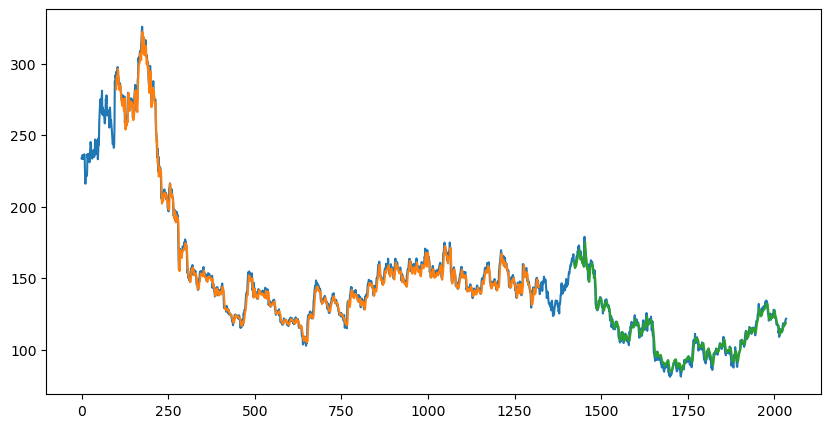

In [30]:
plt.figure(figsize = (10,5))

plt.plot(scaler.inverse_transform(train_scaler))

plt.plot(trainPredictPlot)

plt.plot(testPredictPlot)

plt.show()